In [1]:
from plot import (
    read_results, 
    combine_results,
    get_experimental_data,
    get_absolute_dGs
)
from functions import (
    read_protocol
)
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import (
    spearmanr,
    pearsonr, 
    bootstrap,
    mannwhitneyu,
)
from sklearn.metrics import (
    r2_score,
    mean_absolute_error,
    root_mean_squared_error
)

INFO:rdkit:Enabling RDKit 2023.09.1 jupyter extensions


/home/jguven/projects/metalloenzymes/meze/functions.py:418: RuntimeWarning: Mean of empty slice
  return np.nanmean(values, axis=1)
/home/jguven/projects/metalloenzymes/meze/plot.py:262: UserWarning: Some transformations contained NaNs. Please check /home/jguven/projects/alchemistry/model_1_vim2/outputs///SOMD_results.csv for details.
  warnings.warn(f"Some transformations contained NaNs. Please check {results_file} for details.")
/home/jguven/Software/miniconda3/envs/obss-d/lib/python3.9/site-packages/cinnabar/femap.py:35: UserWarning: Assuming kcal/mol units on measurements
  warnings.warn("Assuming kcal/mol units on measurements")
/home/jguven/projects/metalloenzymes/meze/functions.py:418: RuntimeWarning: Mean of empty slice
  return np.nanmean(values, axis=1)
/home/jguven/projects/metalloenzymes/meze/plot.py:262: UserWarning: Some transformations contained NaNs. Please check /home/jguven/projects/alchemistry/model_1_vim2/outputs///SOMD_results.csv for details.
  warnings.warn(f"Som

In [26]:
def compute_rmse(true, predicted):
    return root_mean_squared_error(true, predicted)

def compute_mae(true, predicted):
    return mean_absolute_error(true, predicted)

def compute_r2_score(true, predicted):
    return r2_score(true, predicted)

def compute_pearsonr(true, predicted):
    return pearsonr(true, predicted)[0]

def compute_spearmanrho(true, predicted):
    return spearmanr(true, predicted)[0]

def compute_statistic(experimental_samples, calculated_samples, statistic):
    if statistic.lower() == "rmse":
        statistic = root_mean_squared_error(y_true=experimental_samples, y_pred=calculated_samples)

    elif statistic.lower() == "mae":
        statistic = mean_absolute_error(y_true=experimental_samples, y_pred=calculated_samples)
    
    elif statistic.lower() == "r2":
        statistic = r2_score(y_true=experimental_samples, y_pred=calculated_samples)

    elif statistic.lower() == "pearson":
        statistic = pearsonr(x=experimental_samples, y=calculated_samples)[0]
    
    elif statistic.lower() == "rho":
        statistic = spearmanr(a=experimental_samples, b=calculated_samples)[0]
    return statistic

def bootstrap_manual(experimental, calculated,  statistic, n_bootstrap_samples=1000, ci=0.95):
    sample_size = len(experimental)
    assert sample_size == len(calculated), f"Calculated ({len(calculated)}) and experimental ({sample_size}) lengths do not match"
    
    bootstrapped_data = np.zeros(
        [n_bootstrap_samples], np.float64
    ) 
    experimental_bootstraps = []
    calculated_bootstraps = []
    for i in range(n_bootstrap_samples):
        if i==0:
            experimental_samples = experimental

            calculated_samples = calculated
        else:
            bootstrap_sample = np.random.choice(range(sample_size), size = sample_size, replace=True)
            experimental_samples = [experimental[i] for i in bootstrap_sample]

            calculated_samples = [calculated[i] for i in bootstrap_sample]
        
        experimental_bootstraps.append(experimental_samples)
        calculated_bootstraps.append(calculated_samples)
        bootstrapped_data[i] = compute_statistic(experimental_samples, 
                                                 calculated_samples,
                                                 statistic)
    mean = np.mean(bootstrapped_data)
    lower_fraction = ((1 - ci)/2.0) * 100

    upper_fraction = 100 - lower_fraction

    lower_bound = np.percentile(bootstrapped_data, lower_fraction)
    upper_bound = np.percentile(bootstrapped_data, upper_fraction)
    return np.array(experimental_bootstraps), np.array(calculated_bootstraps), bootstrapped_data, mean, lower_bound, upper_bound

def plot_hist(data_1, data_2, label_1, label_2, n_bins=100):
    plt.hist(data_1, bins=n_bins, label=label_1)
    plt.hist(data_2, bins=n_bins, label=label_2)
    plt.xlabel("Value")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

# Comparison

In [104]:
working_directory_1 = "/home/jguven/projects/alchemistry/model_1_vim2/"
protocol_file_1 = f"{working_directory_1}/afe/protocol.dat"
experimental_file_1 = f"{working_directory_1}/afe/experimental_K_i.csv"
protocol_1 = read_protocol(protocol_file_1)
transformations_1, free_energies_1, errors_1 = read_results(protocol_1) 
results_1 = combine_results(protocol_1, transformations_1, free_energies_1, errors_1)
absolute_dataframe_1 = get_absolute_dGs(experimental_file=experimental_file_1,
                                      calculated_dataframe=results_1,
                                      protocol=protocol_1)
get_column = lambda column: absolute_dataframe_1[column].to_numpy()
x_data_1 = get_column("exp_dG")
experimental_errors_1 = get_column("exp_err")
calculated_values_1 = get_column("calc_dG")
calculated_errors_1 = get_column("calc_err")
exp_samples_1, calc_samples_1, pearson_distr_1, _, _, _ = bootstrap_manual(experimental=x_data_1,
                                                              calculated=calculated_values_1,
                                                              statistic="pearson",
                                                              n_bootstrap_samples=1000)
working_directory_0 = "/home/jguven/projects/alchemistry/model_0_vim2/"
protocol_file_0 = f"{working_directory_0}/afe/protocol.dat"
experimental_file_0 = f"{working_directory_0}/afe/experimental_K_i.csv"
protocol_0 = read_protocol(protocol_file_0)
transformations_0, free_energies_0, errors_0 = read_results(protocol_0) 
results_0 = combine_results(protocol_0, transformations_0, free_energies_0, errors_0)
absolute_dataframe_0 = get_absolute_dGs(experimental_file=experimental_file_0,
                                      calculated_dataframe=results_0,
                                      protocol=protocol_0)
get_column = lambda column: absolute_dataframe_0[column].to_numpy()
x_data_0 = get_column("exp_dG")
experimental_errors_0 = get_column("exp_err")
calculated_values_0 = get_column("calc_dG")
calculated_errors_0 = get_column("calc_err")
exp_samples_0, calc_samples_0, pearson_distr_0, _, _, _ = bootstrap_manual(experimental=x_data_0,
                                                              calculated=calculated_values_0,
                                                              statistic="pearson",
                                                              n_bootstrap_samples=1000)

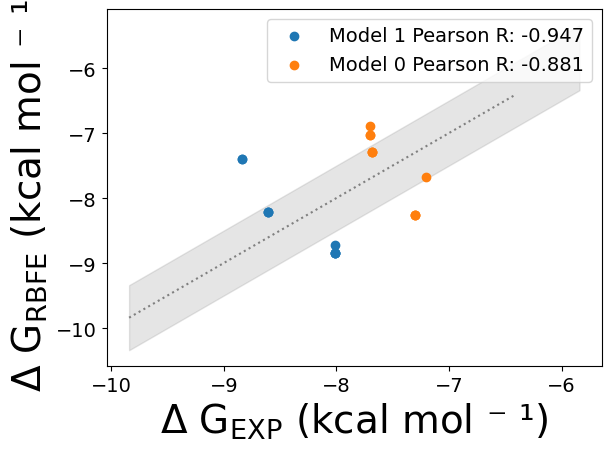

In [105]:

i1 = np.argmin(pearson_distr_1)
i0 = np.argmin(pearson_distr_0)
exp = exp_samples_1[i1]
calc = calc_samples_1[i1]

shift = np.min(exp)

x_data = exp - np.mean(exp) + shift
y_data = calc - np.mean(calc) + shift
plt.scatter(x_data, y_data, label=f"Model 1 Pearson R: {np.round(pearson_distr_1[i1], 3)}")
max_calculated = max(y_data) + 1 
max_experimental = max(x_data) + 1
max_value = max(max_calculated, max_experimental)

min_calculated = min(y_data) - 1
min_experimental = min(x_data) - 1
min_value = min(min_calculated, min_experimental)
top = np.arange(min_value+0.5, max_value+1.5)
bottom = np.arange(min_value-0.5, max_value+0.5)
x = np.arange(min_value, max_value+1)
plt.fill_between(x, bottom, top, alpha=0.2, color="gray", zorder=-1)
plt.plot([min_value, max_value], [min_value, max_value], color="gray", linestyle=":", zorder=-1)

### -----
exp = exp_samples_0[i0]
calc = calc_samples_0[i0]

shift = np.min(exp)

x_data = exp - np.mean(exp) + shift
y_data = calc - np.mean(calc) + shift
plt.scatter(x_data, y_data, label=f"Model 0 Pearson R: {np.round(pearson_distr_0[i0], 3)}")
max_calculated = max(y_data) + 1 
max_experimental = max(x_data) + 1
max_value = max(max_calculated, max_experimental)


plt.xlabel("$\Delta$ G$_\mathrm{EXP}$ (kcal mol \u207B \u00B9)", fontsize=28)
plt.ylabel("$\Delta$ G$_\mathrm{RBFE}$ (kcal mol \u207B \u00B9)", fontsize=28)
plt.legend()
plt.tight_layout()
plt.show()

# Mann-Whitney U Test

In [39]:
working_directory_1 = "/home/jguven/projects/alchemistry/model_1_vim2/"
protocol_file_1 = f"{working_directory_1}/afe/protocol.dat"
experimental_file_1 = f"{working_directory_1}/afe/experimental_K_i.csv"
working_directory_0 = "/home/jguven/projects/alchemistry/model_0_vim2/"
protocol_file_0 = f"{working_directory_0}/afe/protocol.dat"
experimental_file_0 = f"{working_directory_0}/afe/experimental_K_i.csv"

protocol_1 = read_protocol(protocol_file_1)
transformations_1, free_energies_1, errors_1 = read_results(protocol_1) 
results_1 = combine_results(protocol_1, transformations_1, free_energies_1, errors_1)
absolute_dataframe_1 = get_absolute_dGs(experimental_file=experimental_file_1,
                                        calculated_dataframe=results_1,
                                        protocol=protocol_1)
protocol_0 = read_protocol(protocol_file_0)
transformations_0, free_energies_0, errors_0 = read_results(protocol_0) 
results_0 = combine_results(protocol_0, transformations_0, free_energies_0, errors_0)
absolute_dataframe_0 = get_absolute_dGs(experimental_file=experimental_file_0,
                                      calculated_dataframe=results_0,
                                      protocol=protocol_0)

get_column = lambda column: absolute_dataframe_1[column].to_numpy()
x_data_1 = get_column("exp_dG")
experimental_errors_1 = get_column("exp_err")
calculated_values_1 = get_column("calc_dG")
calculated_errors_1 = get_column("calc_err")

get_column = lambda column: absolute_dataframe_0[column].to_numpy()
x_data_0 = get_column("exp_dG")
experimental_errors_0 = get_column("exp_err")
calculated_values_0 = get_column("calc_dG")
calculated_errors_0 = get_column("calc_err")

### Perform stats on shifted values

In [41]:
shift_1 = np.min(x_data_1)
x_data_1 = x_data_1 - np.mean(x_data_1) + shift_1
y_data_1 = calculated_values_1 - np.mean(calculated_values_1) + shift_1
shift_0 = np.min(x_data_0)
x_data_0 = x_data_0 - np.mean(x_data_0) + shift_0
y_data_0 = calculated_values_0 - np.mean(calculated_values_0) + shift_0

## Pearson R

mean model 1: 0.6575020588760069
lower model 1: -0.09550342673522108
upper model 1: 0.9242660084190069
mean: 0.48084009779630005
lower: -0.047138889884916844
upper: 0.8796712345042755


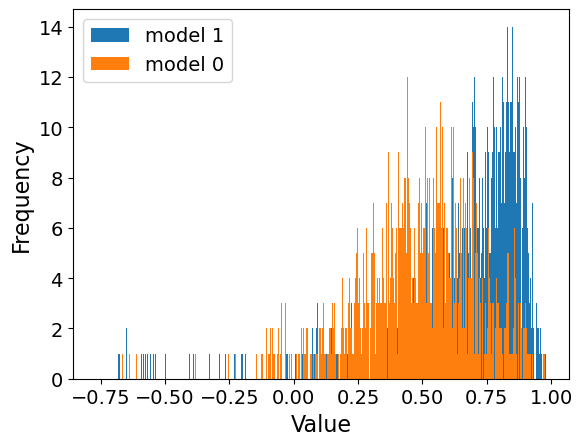

Mann Whitney U: 252857.0 1.2002119495998028e-81


In [42]:
pearsonr_bootstrap_results_1 = bootstrap(data=(x_data_1, y_data_1),
                                         statistic=compute_pearsonr,
                                         method="percentile",
                                         n_resamples=1000,
                                         confidence_level=0.95,
                                         paired=True)
distribution_1 = pearsonr_bootstrap_results_1.bootstrap_distribution
pearson_1 = np.mean(distribution_1)
confidence_interval_1 = pearsonr_bootstrap_results_1.confidence_interval

print(f"mean model 1: {pearson_1}")
print(f"lower model 1: {confidence_interval_1.low}")
print(f"upper model 1: {confidence_interval_1.high}")

pearsonr_bootstrap_results_0 = bootstrap(data=(x_data_0, y_data_0),
                                       statistic=compute_pearsonr,
                                       method="percentile",
                                       n_resamples=1000,
                                       paired=True
                                       )
distribution_0 = pearsonr_bootstrap_results_0.bootstrap_distribution
pearson_0 = np.mean(distribution_0)
confidence_interval_0 = pearsonr_bootstrap_results_0.confidence_interval
print(f"mean: {pearson_0}")
print(f"lower: {confidence_interval_0.low}")
print(f"upper: {confidence_interval_0.high}")

plot_hist(data_1=distribution_1, data_2=distribution_0, label_1="model 1", label_2="model 0", n_bins=500)

pearson_u1, pearson_p = mannwhitneyu(distribution_0, distribution_1)
print(f"Mann Whitney U: {pearson_u1} {pearson_p}")

## Spearman $\rho$

mean model 1: 0.5679815711558388
lower model 1: -0.2397677645364384
upper model 1: 0.9629978094429061


mean: 0.42917950380072195
lower: -0.32611094293279436
upper: 0.8749999999999999


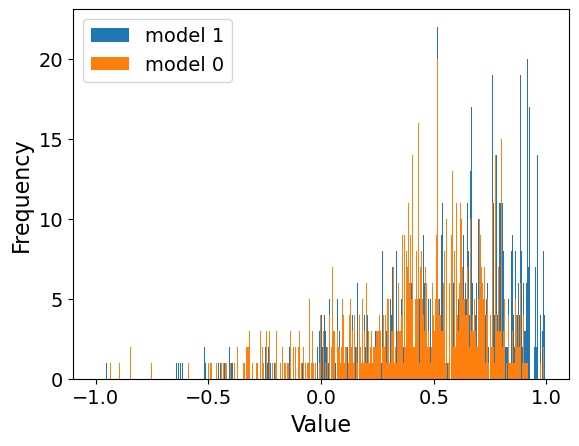

Mann Whitney U: 354611.0 2.0919272511050325e-29


In [43]:
spearman_rho_bootstrap_results_1 = bootstrap(data=(x_data_1, y_data_1),
                                         statistic=compute_spearmanrho,
                                         method="percentile",
                                         n_resamples=1000,
                                         confidence_level=0.95,
                                         paired=True)
distribution_1 = spearman_rho_bootstrap_results_1.bootstrap_distribution
spearman_1 = np.mean(distribution_1)
confidence_interval_1 = spearman_rho_bootstrap_results_1.confidence_interval

print(f"mean model 1: {spearman_1}")
print(f"lower model 1: {confidence_interval_1.low}")
print(f"upper model 1: {confidence_interval_1.high}")

spearman_rho_bootstrap_results_0 = bootstrap(data=(x_data_0, y_data_0),
                                       statistic=compute_spearmanrho,
                                       method="percentile",
                                       n_resamples=1000,
                                       paired=True
                                       )
distribution_0 = spearman_rho_bootstrap_results_0.bootstrap_distribution
spearman_0 = np.mean(distribution_0)
confidence_interval_0 = spearman_rho_bootstrap_results_0.confidence_interval
print(f"mean: {spearman_0}")
print(f"lower: {confidence_interval_0.low}")
print(f"upper: {confidence_interval_0.high}")

plot_hist(data_1=distribution_1, data_2=distribution_0, label_1="model 1", label_2="model 0", n_bins=500)

spearman_u1, spearman_p = mannwhitneyu(distribution_0, distribution_1)
print(f"Mann Whitney U: {spearman_u1} {spearman_p}")

## RMSE

mean model 1: 0.8899541190156174
lower model 1: 0.6260575858599442
upper model 1: 1.123831119009371
mean: 1.029601334000904
lower: 0.48625821379706013
upper: 1.5632168364651118


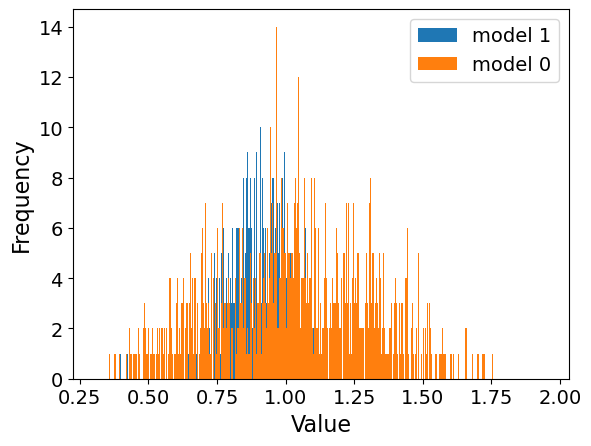

Mann Whitney U: 670843.0 5.881204110691027e-40


In [44]:
rmse_bootstrap_results_1 = bootstrap(data=(x_data_1, y_data_1),
                                         statistic=compute_rmse,
                                         method="percentile",
                                         n_resamples=1000,
                                         confidence_level=0.95,
                                         paired=True)
distribution_1 = rmse_bootstrap_results_1.bootstrap_distribution
rmse_1 = np.mean(distribution_1)
confidence_interval_1 = rmse_bootstrap_results_1.confidence_interval

print(f"mean model 1: {rmse_1}")
print(f"lower model 1: {confidence_interval_1.low}")
print(f"upper model 1: {confidence_interval_1.high}")

rmse_bootstrap_results_0 = bootstrap(data=(x_data_0, y_data_0),
                                       statistic=compute_rmse,
                                       method="percentile",
                                       n_resamples=1000,
                                       paired=True
                                       )
distribution_0 = rmse_bootstrap_results_0.bootstrap_distribution
rmse_0 = np.mean(distribution_0)
confidence_interval_0 = rmse_bootstrap_results_0.confidence_interval
print(f"mean: {rmse_0}")
print(f"lower: {confidence_interval_0.low}")
print(f"upper: {confidence_interval_0.high}")

plot_hist(data_1=distribution_1, data_2=distribution_0, label_1="model 1", label_2="model 0", n_bins=500)

rmse_u1, rmse_p = mannwhitneyu(distribution_0, distribution_1)
print(f"Mann Whitney U: {rmse_u1} {rmse_p}")

## MUE

mean model 1: 0.7517433273753409
lower model 1: 0.435949128667154
upper model 1: 1.0568394116166149
mean: 0.7737938711328933
lower: 0.3538090274952316
upper: 1.2641175571934382


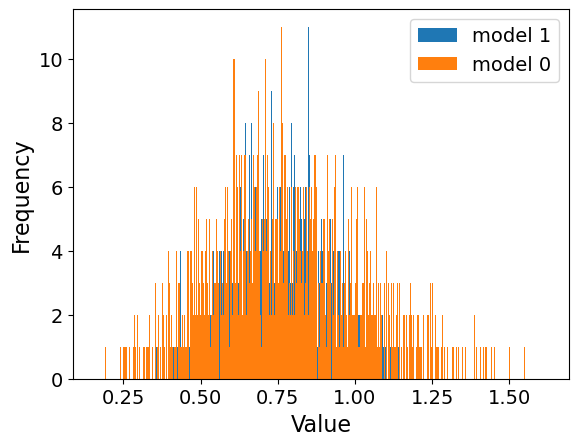

Mann Whitney U: 514138.0 0.27359883941351704


In [45]:
mae_bootstrap_results_1 = bootstrap(data=(x_data_1, y_data_1),
                                         statistic=compute_mae,
                                         method="percentile",
                                         n_resamples=1000,
                                         confidence_level=0.95,
                                         paired=True)
distribution_1 = mae_bootstrap_results_1.bootstrap_distribution
mae_1 = np.mean(distribution_1)
confidence_interval_1 = mae_bootstrap_results_1.confidence_interval

print(f"mean model 1: {mae_1}")
print(f"lower model 1: {confidence_interval_1.low}")
print(f"upper model 1: {confidence_interval_1.high}")

mae_bootstrap_results_0 = bootstrap(data=(x_data_0, y_data_0),
                                       statistic=compute_mae,
                                       method="percentile",
                                       n_resamples=1000,
                                       paired=True
                                       )
distribution_0 = mae_bootstrap_results_0.bootstrap_distribution
mae_0 = np.mean(distribution_0)
confidence_interval_0 = mae_bootstrap_results_0.confidence_interval
print(f"mean: {mae_0}")
print(f"lower: {confidence_interval_0.low}")
print(f"upper: {confidence_interval_0.high}")

plot_hist(data_1=distribution_1, data_2=distribution_0, label_1="model 1", label_2="model 0", n_bins=500)

mae_u1, mae_p = mannwhitneyu(distribution_0, distribution_1)
print(f"Mann Whitney U: {mae_u1} {mae_p}")

# Model 1

In [7]:
working_directory = "/home/jguven/projects/alchemistry/model_1_vim2/"
protocol_file = f"{working_directory}/afe/protocol.dat"
experimental_file = f"{working_directory}/afe/experimental_K_i.csv"

In [8]:
protocol = read_protocol(protocol_file)
transformations, free_energies, errors = read_results(protocol) 
results = combine_results(protocol, transformations, free_energies, errors)
absolute_dataframe = get_absolute_dGs(experimental_file=experimental_file,
                                      calculated_dataframe=results,
                                      protocol=protocol)
absolute_dataframe

,label,exp_dG,exp_err,calc_dG,calc_err
0,ligand_2,-7.793958,0.056777,-0.571977,0.143196
1,ligand_6,-8.354581,0.072703,0.353213,0.073940
2,ligand_8,-7.524502,0.018065,-0.969830,0.083567
3,ligand_9,-8.127579,0.079488,-0.457843,0.070890
4,ligand_10,-7.524502,0.005420,-1.082885,0.085610
5,ligand_11,-7.129619,0.003726,-0.330954,0.079446
6,ligand_12,-7.035065,0.001590,1.713554,0.267394
7,ligand_13,-7.506705,0.005260,0.011349,0.076265
8,ligand_15,-6.202678,0.062961,2.906903,0.110250
9,ligand_16,-8.923058,0.028299,-1.571528,0.073917


In [9]:
get_column = lambda column: absolute_dataframe[column].to_numpy()
x_data = get_column("exp_dG")
experimental_errors = get_column("exp_err")
calculated_values = get_column("calc_dG")
calculated_errors = get_column("calc_err")

### Pearson r

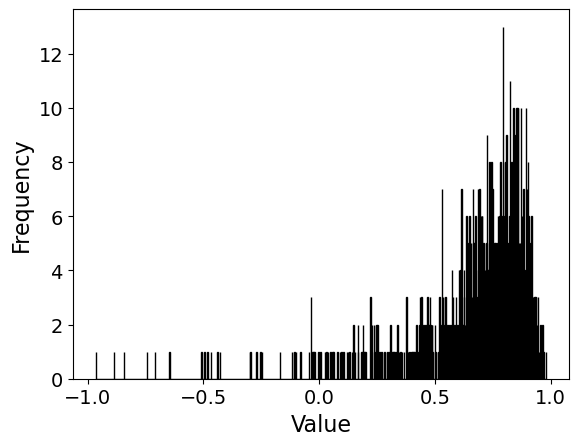

mean: 0.6695813097393167
lower: 0.27046330678984654
upper: 0.9002242020978329


In [22]:
pearsonr_bootstrap_results = bootstrap(data=(x_data, calculated_values),
                                       statistic=compute_pearsonr,
                                       method="percentile",
                                       n_resamples=1000,
                                       confidence_level=0.83,
                                       paired=True)
distribution_model = pearsonr_bootstrap_results.bootstrap_distribution
pearson = np.mean(distribution_model)
confidence_interval = pearsonr_bootstrap_results.confidence_interval
plot_hist(distribution_model, n_bins=1000)
print(f"mean: {pearson}")
print(f"lower: {confidence_interval.low}")
print(f"upper: {confidence_interval.high}")

**My function:**

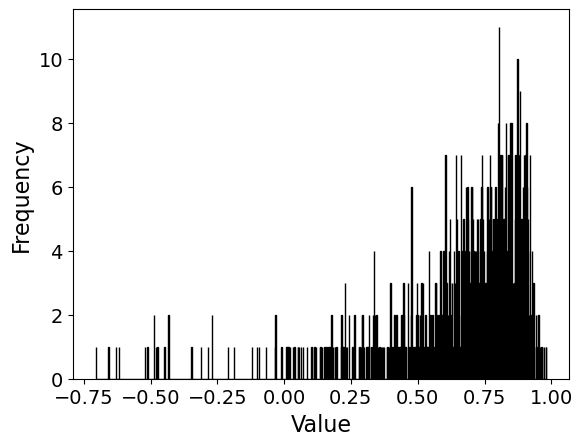

mean: 0.6678134991542015
lower: -0.031772641099755985
upper: 0.9247203018741957


In [11]:
exp_samples, calc_samples, pearson_distr, pearson, pearson_low, pearson_high = bootstrap_manual(experimental=x_data,
                                                              calculated=calculated_values,
                                                              statistic="pearson",
                                                              n_bootstrap_samples=1000)
plot_hist(pearson_distr, n_bins=1000)
print(f"mean: {pearson}")
print(f"lower: {pearson_low}")
print(f"upper: {pearson_high}")

In [12]:
exp_samples

array([[-7.79395811, -8.35458119, -7.52450208, ..., -7.5067049 ,
        -6.20267825, -8.92305801],
       [-7.5067049 , -8.92305801, -8.12757937, ..., -8.92305801,
        -7.03506527, -7.5067049 ],
       [-7.12961944, -7.5067049 , -7.03506527, ..., -8.12757937,
        -8.92305801, -7.03506527],
       ...,
       [-7.52450208, -6.20267825, -7.52450208, ..., -7.03506527,
        -7.52450208, -8.35458119],
       [-8.92305801, -7.52450208, -8.35458119, ..., -6.20267825,
        -8.12757937, -7.79395811],
       [-7.03506527, -7.79395811, -6.20267825, ..., -7.03506527,
        -8.92305801, -7.12961944]])

In [13]:
calc_samples.shape

(1000, 10)

In [14]:
pearson_distr

array([ 0.74175505,  0.81083237,  0.77849209,  0.82045043,  0.16925076,
        0.73541589,  0.61668499,  0.31827466,  0.87736726,  0.6461023 ,
        0.68053505,  0.85414013,  0.78276372,  0.1919882 ,  0.77424613,
        0.56300898,  0.78488751,  0.86443615,  0.29436341,  0.74155335,
        0.34026932,  0.74977363,  0.33317058,  0.80148982,  0.72244752,
        0.64447423,  0.45595779, -0.03133765,  0.51953859, -0.44793898,
        0.80239961,  0.35075282,  0.83909266,  0.86613001,  0.92637759,
        0.8152022 ,  0.22101513,  0.78694461,  0.68010271,  0.90113199,
        0.80454874,  0.52314805,  0.71269512,  0.83570995,  0.69853195,
        0.35662529,  0.62066416,  0.77221456,  0.69207847,  0.47834757,
        0.54080946,  0.8114673 ,  0.32500653,  0.73251805,  0.81293314,
        0.24309217,  0.92084586,  0.36131767,  0.68640316,  0.88450556,
        0.90685011,  0.82604152,  0.7524217 ,  0.66176077,  0.44616305,
        0.74459816,  0.66994088,  0.78306041,  0.79241081,  0.71

In [15]:
pearson_distr.shape

(1000,)

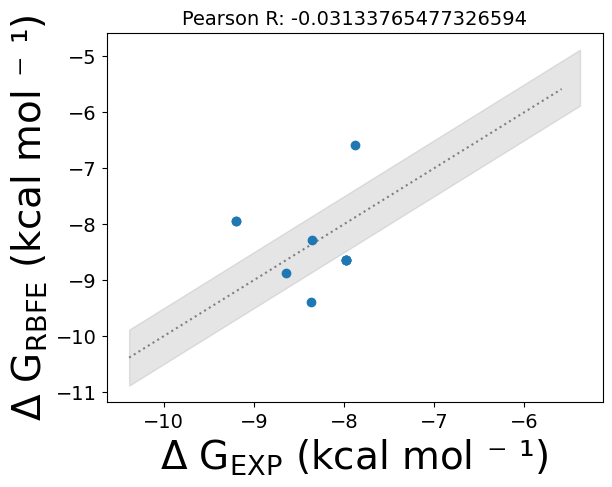

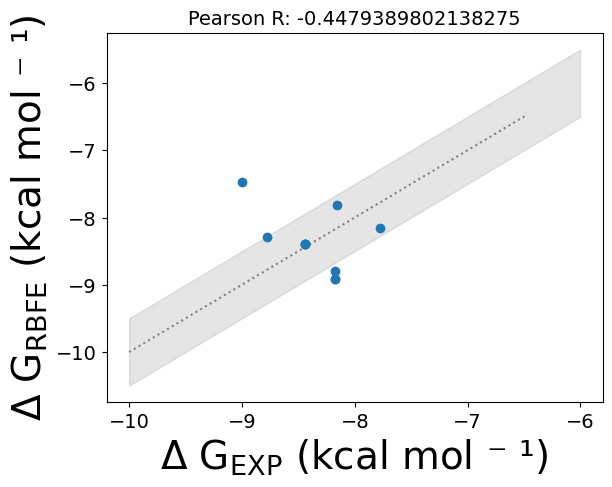

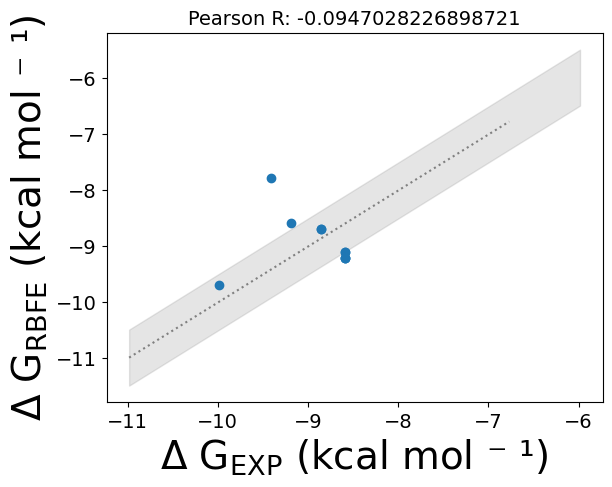

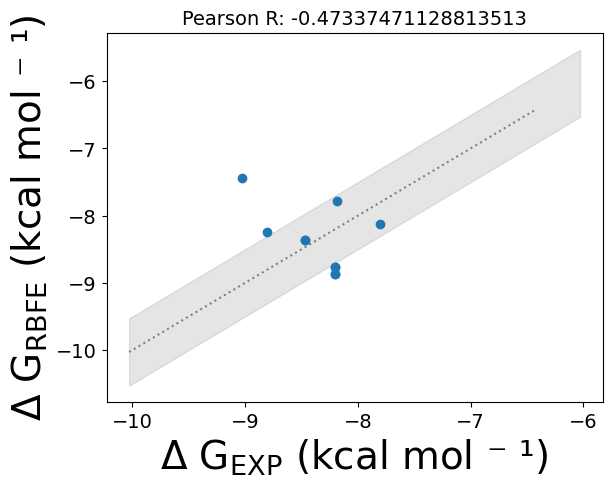

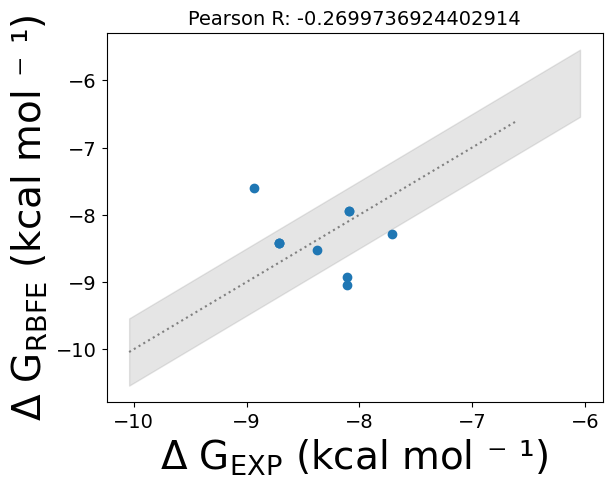

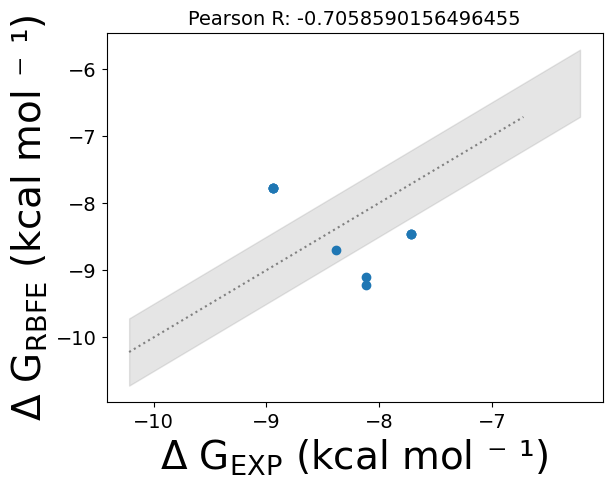

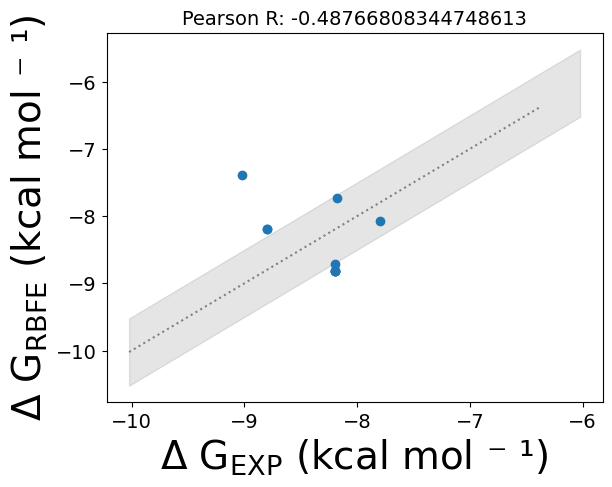

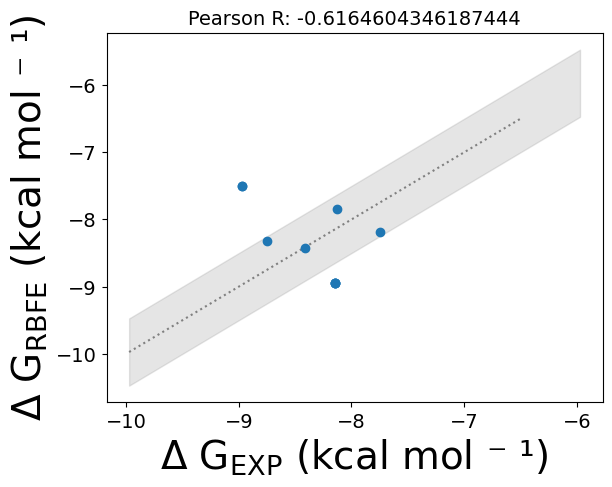

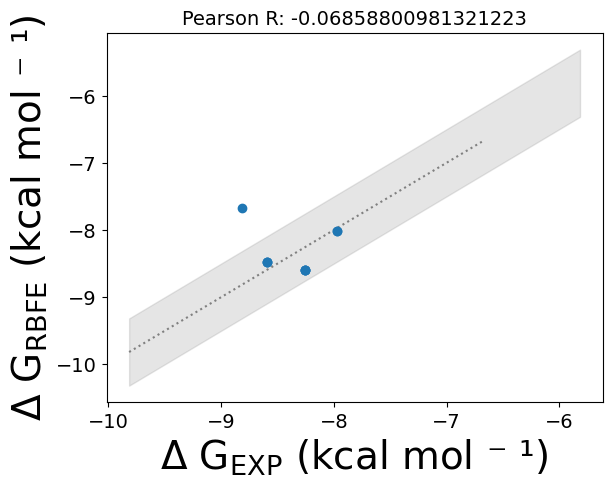

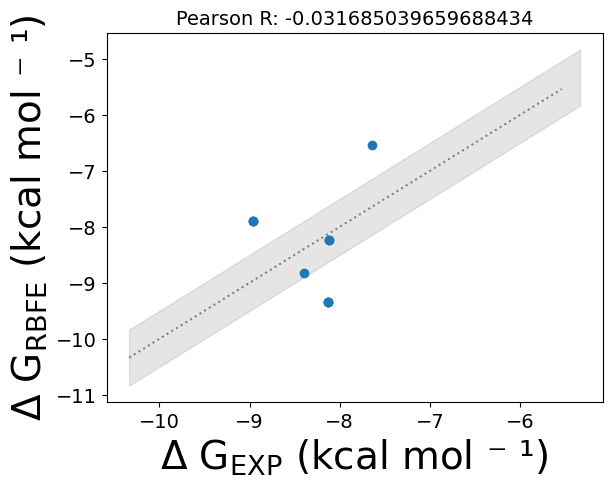

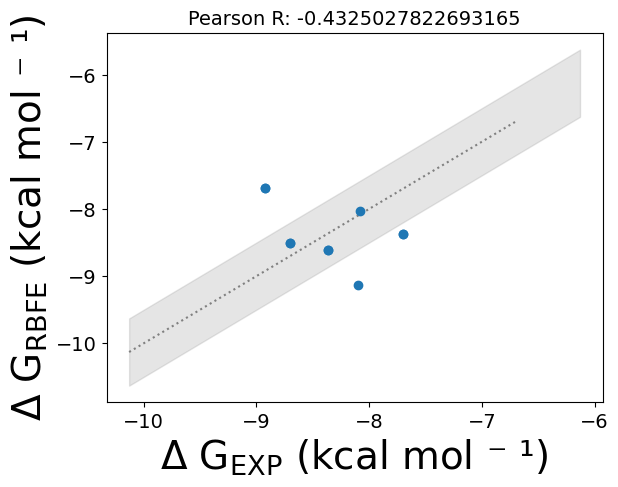

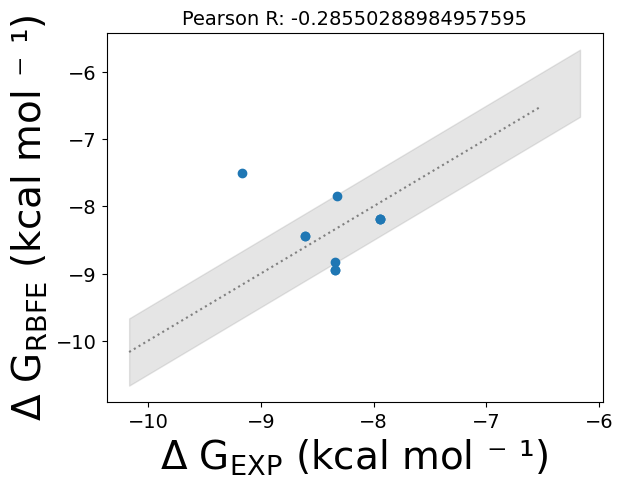

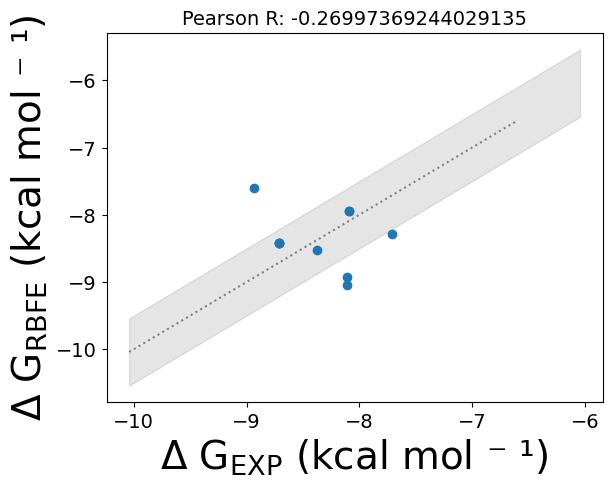

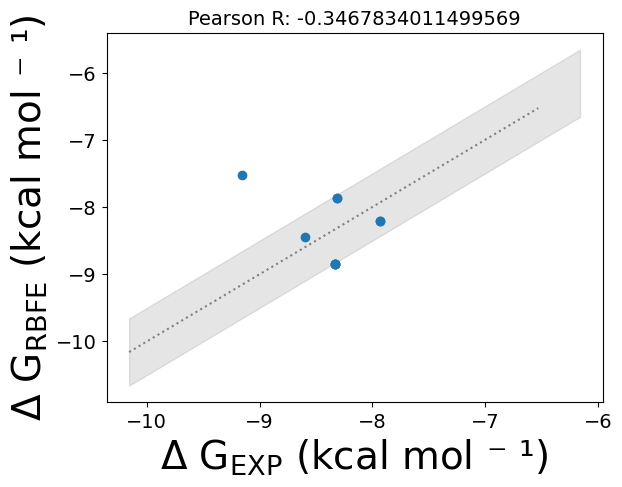

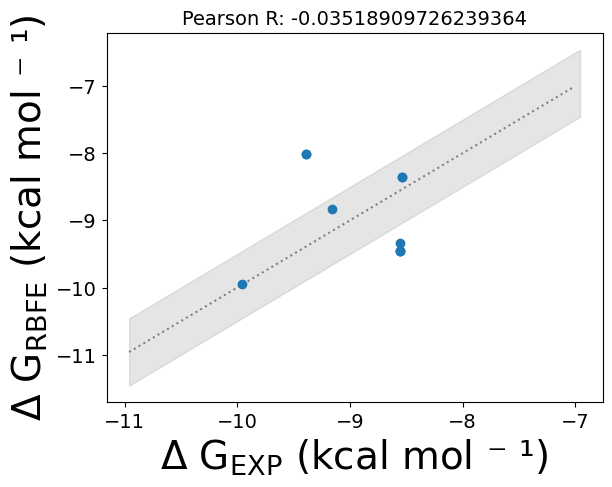

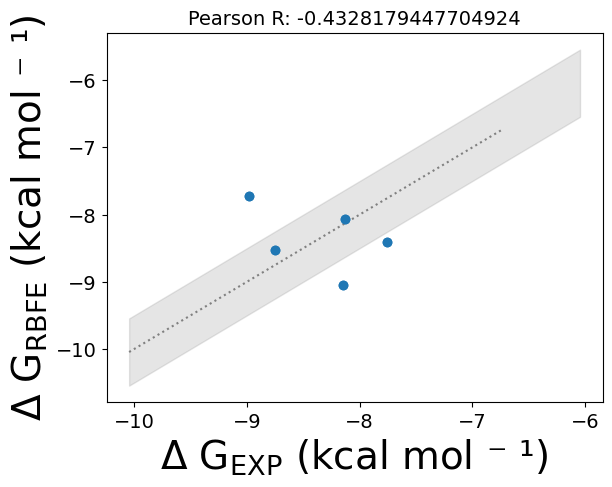

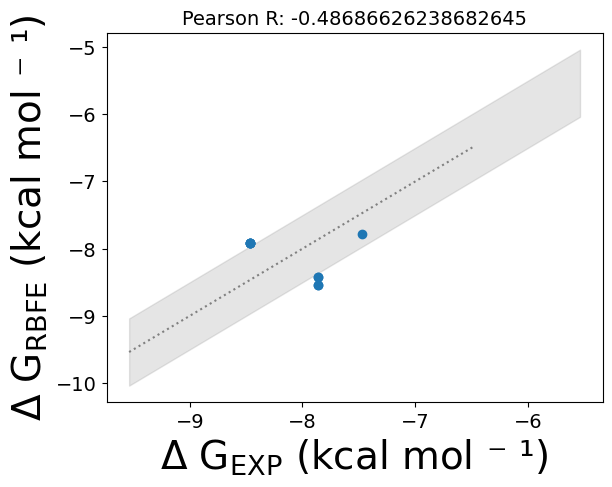

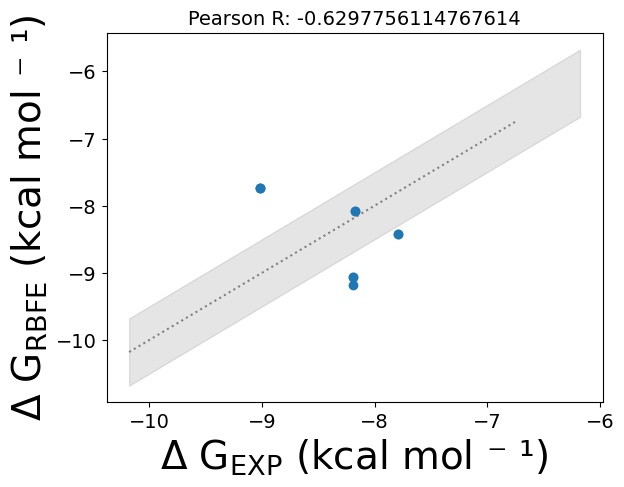

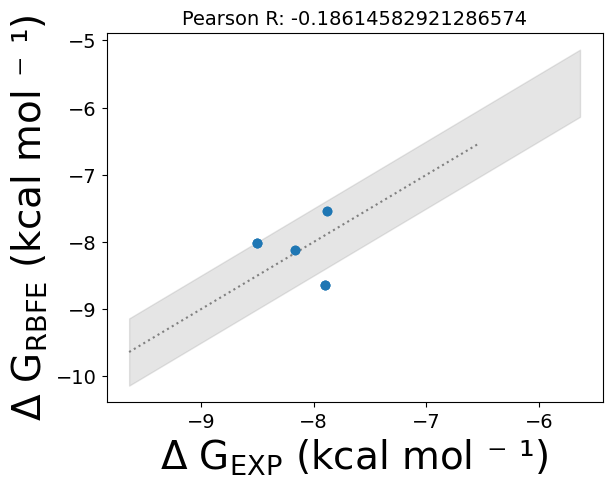

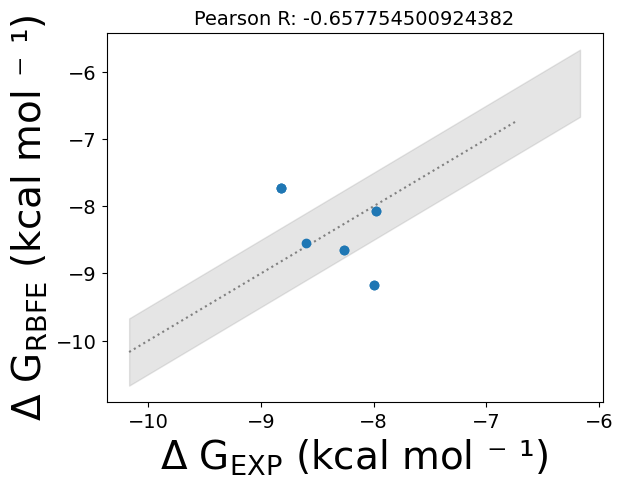

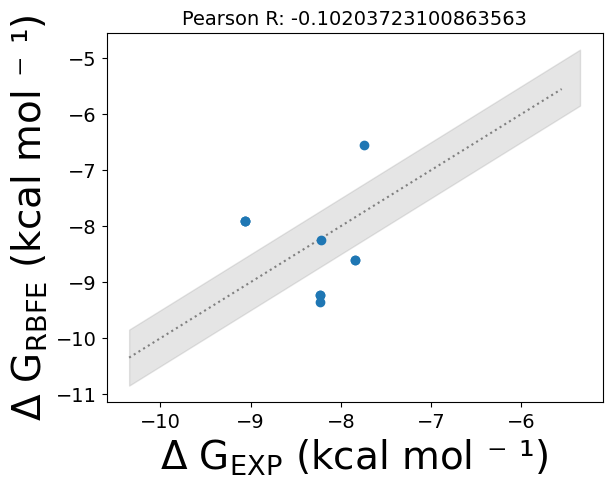

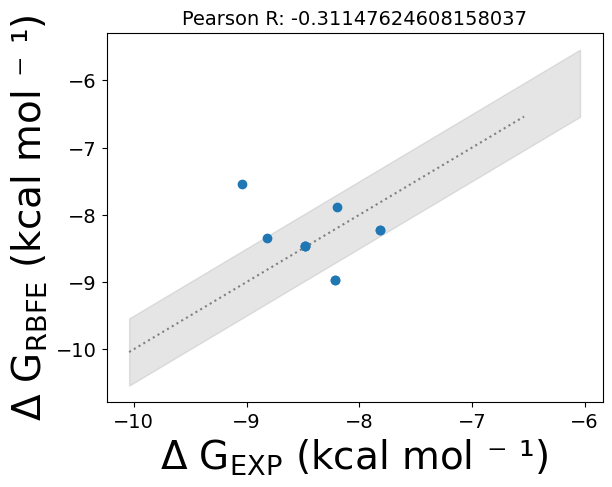

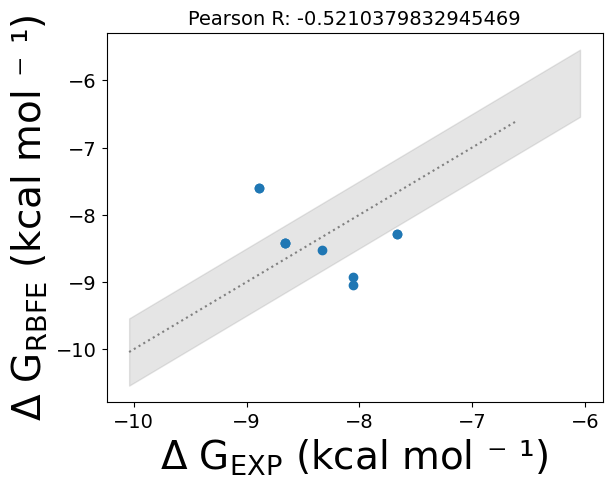

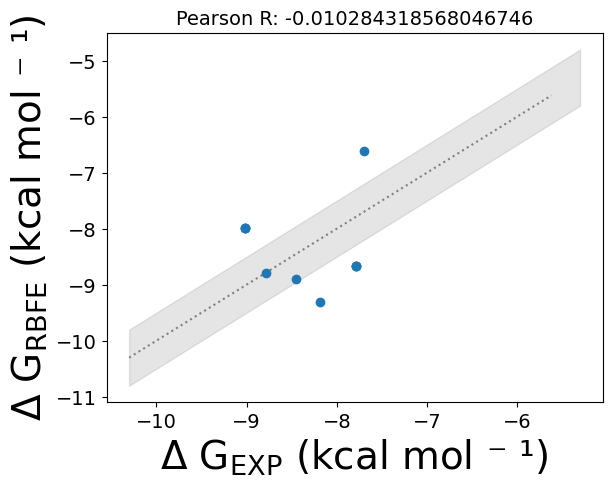

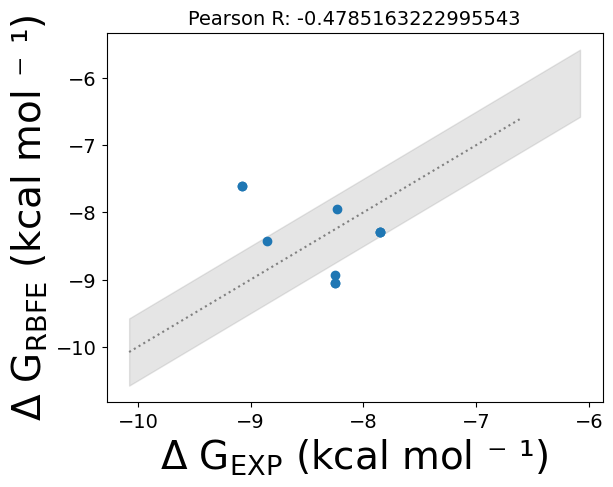

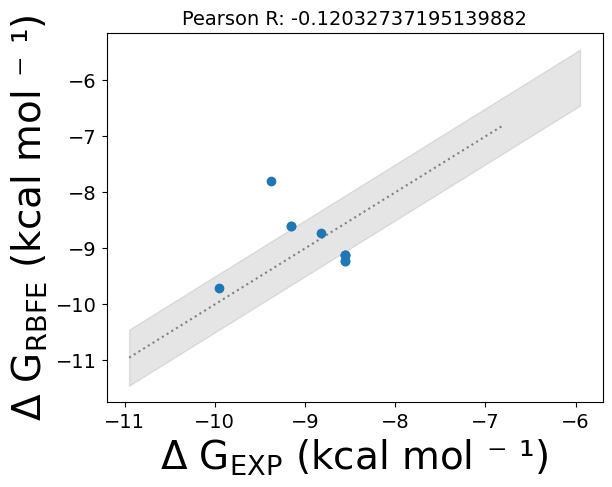

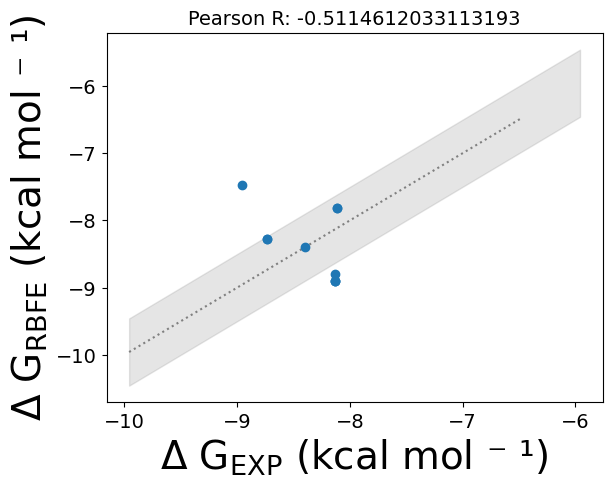

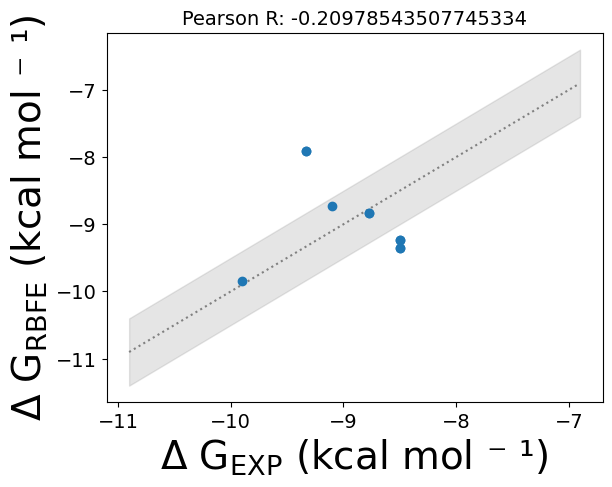

In [16]:
indices = np.where(pearson_distr < 0)[0]

for i in indices:
    exp = exp_samples[i]
    calc = calc_samples[i]
    shift = np.min(exp)
    # shift = 0
    # from https://github.com/OpenFreeEnergy/cinnabar/blob/c140fea77d4019119ed40acd1a699b92ed6bbf10/cinnabar/plotting.py#L377
    x_data = exp - np.mean(exp) + shift
    y_data = calc - np.mean(calc) + shift
    max_calculated = max(y_data) + 1 
    max_experimental = max(x_data) + 1
    max_value = max(max_calculated, max_experimental)

    min_calculated = min(y_data) - 1
    min_experimental = min(x_data) - 1
    min_value = min(min_calculated, min_experimental)
    top = np.arange(min_value+0.5, max_value+1.5)
    bottom = np.arange(min_value-0.5, max_value+0.5)
    x = np.arange(min_value, max_value+1)
    plt.fill_between(x, bottom, top, alpha=0.2, color="gray", zorder=-1)
    plt.plot([min_value, max_value], [min_value, max_value], color="gray", linestyle=":", zorder=-1)
    plt.scatter(x_data, y_data)
    plt.title(f"Pearson R: {pearson_distr[i]}")
    plt.xlabel("$\Delta$ G$_\mathrm{EXP}$ (kcal mol \u207B \u00B9)", fontsize=28)
    plt.ylabel("$\Delta$ G$_\mathrm{RBFE}$ (kcal mol \u207B \u00B9)", fontsize=28)
    plt.show()

10

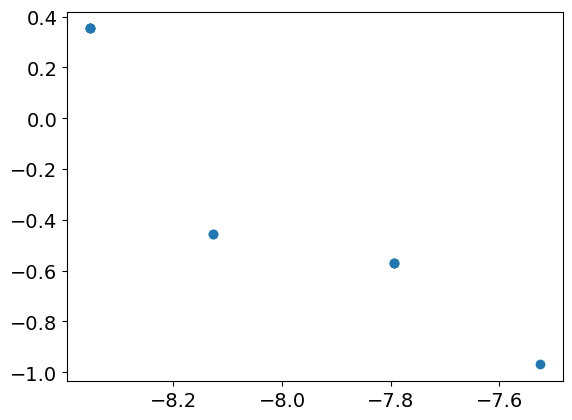

array([ 0.35321255,  0.35321255, -0.45784278, -0.45784278,  0.35321255,
        0.35321255, -0.96983043, -0.57197711, -0.57197711, -0.57197711])

## Spearman

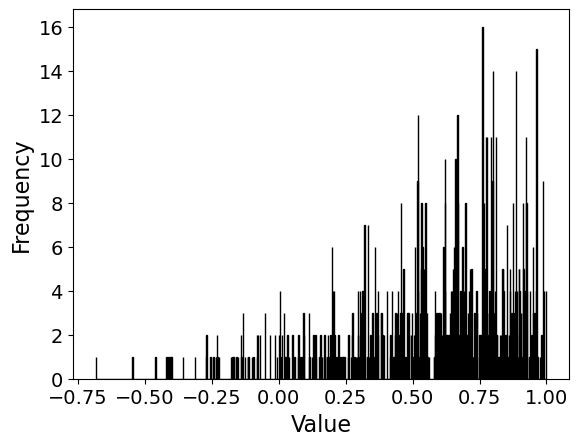

mean: 0.5812640448754001
lower: -0.16934859202819058
upper: 0.9622641509433963


In [18]:
spearman_rho_bootstrap_results = bootstrap(data=(x_data, calculated_values),
                                       statistic=compute_spearmanrho,
                                       method="percentile",
                                       n_resamples=1000,
                                       paired=True)
distribution = spearman_rho_bootstrap_results.bootstrap_distribution
pearson = np.mean(distribution)
confidence_interval = spearman_rho_bootstrap_results.confidence_interval
plot_hist(distribution, n_bins=1000)
print(f"mean: {pearson}")
print(f"lower: {confidence_interval.low}")
print(f"upper: {confidence_interval.high}")

**My function**

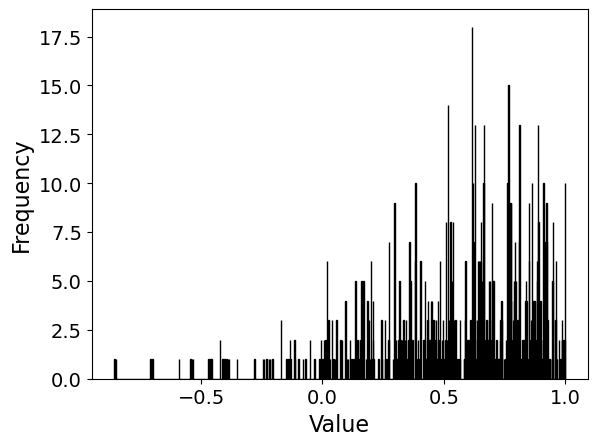

mean: 0.5670214457264321
lower: -0.23099372067457905
upper: 0.9627871283071423


In [7]:
rho_distr, rho, rho_low, rho_high = bootstrap_manual(experimental=x_data,
                                              calculated=calculated_values,
                                              statistic="rho",
                                              n_bootstrap_samples=1000)
plot_hist(rho_distr, n_bins=1000)
print(f"mean: {rho}")
print(f"lower: {rho_low}")
print(f"upper: {rho_high}")

## MAE

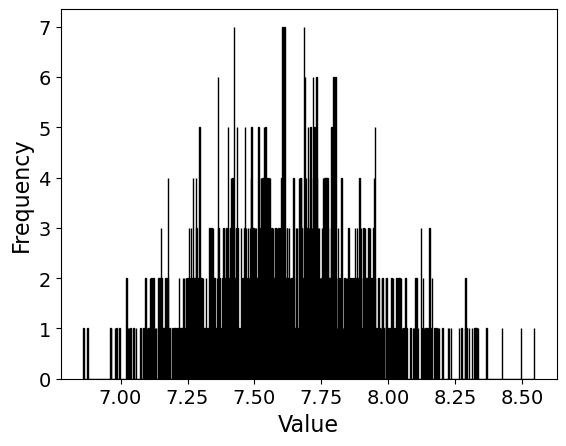

mean: 7.619390071524607
lower: 7.1109953608026055
upper: 8.16237446254835


In [8]:
mae_distr, mae, mae_low, mae_high = bootstrap_manual(experimental=x_data,
                                              calculated=calculated_values,
                                              statistic="mae",
                                              n_bootstrap_samples=1000)
plot_hist(mae_distr, n_bins=1000)
print(f"mean: {mae}")
print(f"lower: {mae_low}")
print(f"upper: {mae_high}")

## RMSE


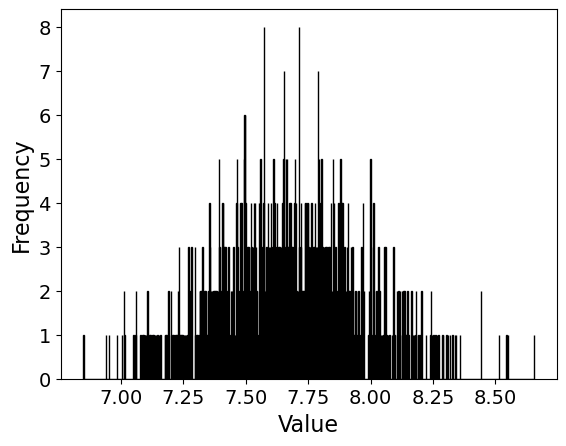

mean: 7.662839178082392
lower: 7.125339533876374
upper: 8.223194264581391


In [9]:
rmse_distr, rmse, rmse_low, rmse_high = bootstrap_manual(experimental=x_data,
                                              calculated=calculated_values,
                                              statistic="rmse",
                                              n_bootstrap_samples=1000)
plot_hist(rmse_distr, n_bins=1000)
print(f"mean: {rmse}")
print(f"lower: {rmse_low}")
print(f"upper: {rmse_high}")

# Model 0

In [19]:
working_directory = "/home/jguven/projects/alchemistry/model_0_vim2/"
protocol_file = f"{working_directory}/afe/protocol.dat"
experimental_file = f"{working_directory}/afe/experimental_K_i.csv"


In [20]:
protocol = read_protocol(protocol_file)
transformations, free_energies, errors = read_results(protocol) 
results = combine_results(protocol, transformations, free_energies, errors)
absolute_dataframe = get_absolute_dGs(experimental_file=experimental_file,
                                      calculated_dataframe=results,
                                      protocol=protocol)
absolute_dataframe

,label,exp_dG,exp_err,calc_dG,calc_err
0,ligand_2,-7.793958,0.056777,-2.703135,0.204047
1,ligand_6,-8.354581,0.072703,0.778795,0.114841
2,ligand_8,-7.524502,0.018065,1.063872,0.130315
3,ligand_9,-8.127579,0.079488,-0.691855,0.107380
4,ligand_10,-7.524502,0.005420,0.911465,0.124754
5,ligand_11,-7.129619,0.003726,-0.304710,0.329641
6,ligand_12,-7.035065,0.001590,0.278411,0.230485
7,ligand_13,-7.506705,0.005260,0.663411,0.125475
8,ligand_15,-6.202678,0.062961,1.324241,0.181865
9,ligand_16,-8.923058,0.028299,-1.320494,0.120640


In [21]:
get_column = lambda column: absolute_dataframe[column].to_numpy()
x_data = get_column("exp_dG")
experimental_errors = get_column("exp_err")
calculated_values = get_column("calc_dG")
calculated_errors = get_column("calc_err")


### Pearson R

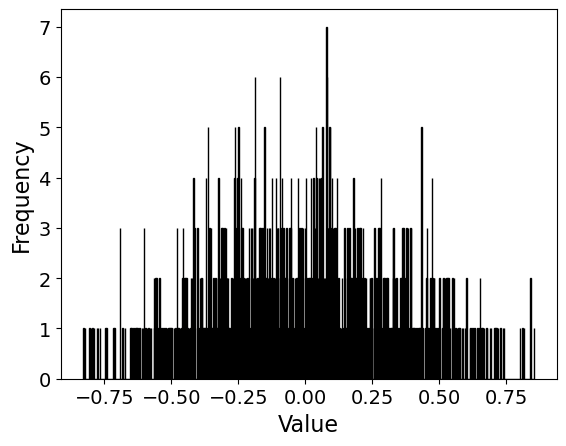

mean: 0.0017842671530576297
lower: -0.6298667212796403
upper: 0.6488833413163081


In [18]:
pearsonr_bootstrap_results = bootstrap(data=(x_data, calculated_values),
                                       statistic=compute_pearsonr,
                                       method="percentile",
                                       n_resamples=1000,
                                       paired=True
                                       )
distribution = pearsonr_bootstrap_results.bootstrap_distribution
pearson = np.mean(distribution)
confidence_interval = pearsonr_bootstrap_results.confidence_interval
plot_hist(distribution, n_bins=1000)
print(f"mean: {pearson}")
print(f"lower: {confidence_interval.low}")
print(f"upper: {confidence_interval.high}")

**My function**

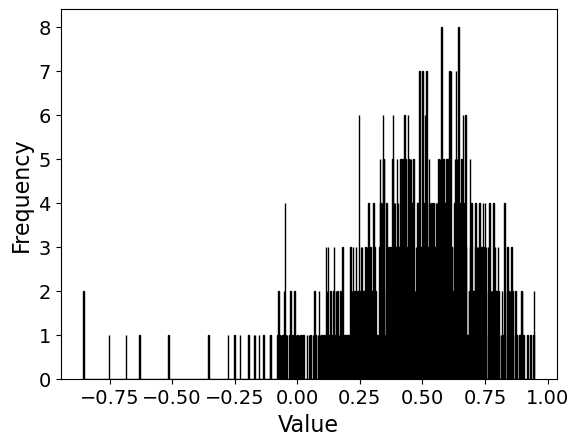

mean: 0.47381072886902026
lower: -0.05284132403065114
upper: 0.8547106359058108


In [13]:
pearson_distr, pearson, pearson_low, pearson_high = bootstrap_manual(experimental=x_data,
                                                              calculated=calculated_values,
                                                              statistic="pearson",
                                                              n_bootstrap_samples=1000)
plot_hist(pearson_distr, n_bins=1000)
print(f"mean: {pearson}")
print(f"lower: {pearson_low}")
print(f"upper: {pearson_high}")

## Spearman $\rho$

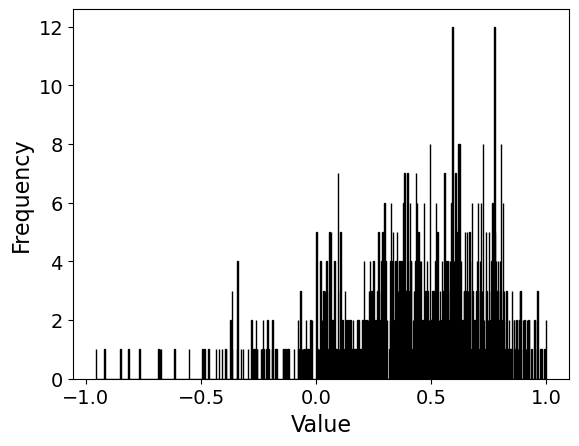

mean: 0.43253000696155774
lower: -0.3428922678455761
upper: 0.89873417721519


In [14]:
rho_distr, rho, rho_low, rho_high = bootstrap_manual(experimental=x_data,
                                              calculated=calculated_values,
                                              statistic="rho",
                                              n_bootstrap_samples=1000)
plot_hist(rho_distr, n_bins=1000)
print(f"mean: {rho}")
print(f"lower: {rho_low}")
print(f"upper: {rho_high}")

## Coefficient of determination (R2 score)

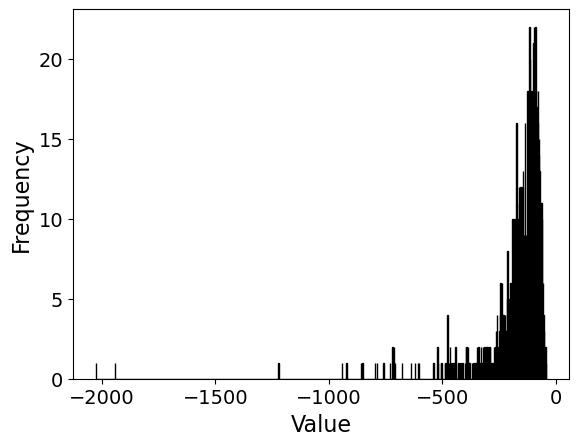

mean: -167.71722427848783
lower: -507.85753121618706
upper: -59.63840803568427


In [15]:
r2_distr, r2, r2_low, r2_high = bootstrap_manual(experimental=x_data,
                                              calculated=calculated_values,
                                              statistic="r2",
                                              n_bootstrap_samples=1000)
plot_hist(r2_distr, n_bins=1000)
print(f"mean: {r2}")
print(f"lower: {r2_low}")
print(f"upper: {r2_high}")

## Mean absolute error

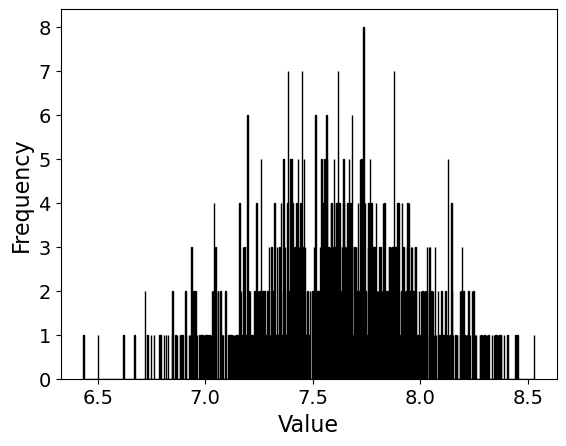

mean: 7.620563987276599
lower: 6.9243167890079285
upper: 8.250721524721945


In [16]:
mae_distr, mae, mae_low, mae_high = bootstrap_manual(experimental=x_data,
                                              calculated=calculated_values,
                                              statistic="mae",
                                              n_bootstrap_samples=1000)
plot_hist(mae_distr, n_bins=1000)
print(f"mean: {mae}")
print(f"lower: {mae_low}")
print(f"upper: {mae_high}")

## Root mean squared error

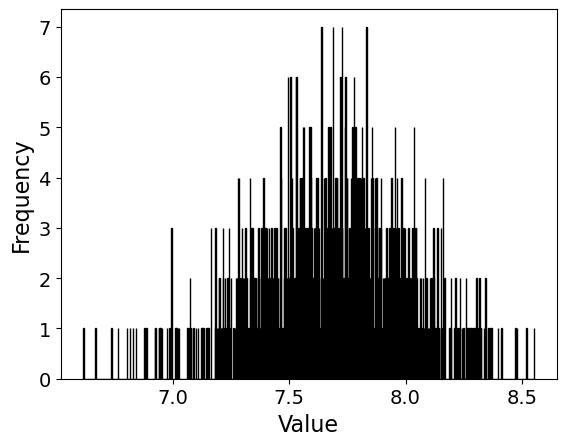

mean: 7.68287457411725
lower: 7.021588464987876
upper: 8.271858665992882


In [17]:
rmse_distr, rmse, rmse_low, rmse_high = bootstrap_manual(experimental=x_data,
                                              calculated=calculated_values,
                                              statistic="rmse",
                                              n_bootstrap_samples=1000)
plot_hist(rmse_distr, n_bins=1000)
print(f"mean: {rmse}")
print(f"lower: {rmse_low}")
print(f"upper: {rmse_high}")